# sleep() 和 wait() 的区别
结合synchronized，会更好的理解sleep()和wait()这两个方法，当然也就知道了他们的区别了。

## sleep()
sleep() 方法是线程类（Thread）的静态方法，让调用线程进入睡眠状态，让出执行机会给其他线程，等到休眠时间结束后，线程进入就绪状态和其他线程一起竞争cpu的执行时间。
**因为sleep() 是static静态的方法，他不能改变对象的机锁，当一个synchronized块中调用了sleep() 方法，线程虽然进入休眠，但是对象的机锁没有被释放，其他线程依然无法访问这个对象。**

下面用一个例子来演示：

Service类：

In [1]:
public class Service {

    public void mSleep(){
        synchronized(this){
            try{
                System.out.println(" Sleep 。当前时间："+System.currentTimeMillis());
                Thread.sleep(3*1000);
            }
            catch(Exception e){
                System.out.println(e);
            }
        }
    }

    public void mWait(){
        synchronized(this){
            System.out.println(" Wait 。结束时间："+System.currentTimeMillis());

        }
    }

}

就定义了两个方法， mSleep()方法会让调用线程休眠3秒，mWait() 就打印一句话。两个方法都使用了同步锁。

SleepThread类：

In [2]:
public class SleepThread implements Runnable{

    private Service service;

    public SleepThread(Service service){
        this.service = service;
    }

    public void run(){
        service.mSleep();
    }

}

线程类，用于调用Service 的mSleep方法

WaitThread类：

In [3]:
public class WaitThread implements Runnable{

    private Service service;

    public WaitThread(Service service){
        this.service = service;
    }

    public void run(){
        service.mWait();
    }

}

线程类，用于调用Service 的mWait方法

测试类：

In [4]:
public class Test{
    public static void main(){

        Service mService = new Service();

        Thread sleepThread = new Thread(new SleepThread(mService));
        Thread waitThread = new Thread(new WaitThread(mService));
        sleepThread.start();
        waitThread.start();

    }

}

In [5]:
Test.main();

 Sleep 。当前时间：1597738155934

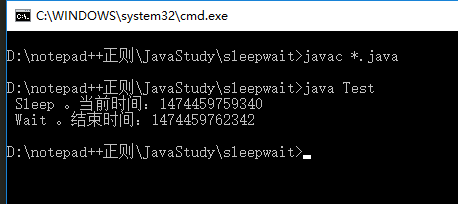

### 梳理一下逻辑：

首先sleepThread线程会启动起来，然后在run方法里调用Service对象的mSleep方法，到了同步代码块后，this就是Test类里创建的Service对象mService，sleepThread线程获得了Service对象的锁，之后进入了休眠状态，但并没有释放该Service对象的锁。
这时waitThread线程也启动了起来，调用Service对象的mWait方法，同样到了同步代码块，因为Service对象的锁已经被sleepThread占了，所以waitThread线程只能干等着。
等到sleepThread线程执行完毕（休眠结束）后释放了同步锁，waitThread线程拿到了同步锁，会继续执行，mWait才会被调用。

如果sleepThread释放了机锁的话，waitThread 的任务会马上得到执行。从打印结果可以看出，waitThread 的任务是3秒钟之后才得到执行。

同步锁，锁住的是一个对象。如果一个线程拿到了一个对象的机锁去执行一段同步代码块了，那么其他线程都不能执行这个对象的其他同步代码块。
在这个例子中就是sleepThread线程拿到了service对象的同步锁，进入后休眠，但没有释放机锁，那么waitThread线程是不能执行这个service对象的其他同步代码块的，也就就是不能进入这一段代码

In [8]:
class Test{
    public void test(){
        synchronized(this){
            System.out.println(" Wait 。结束时间："+System.currentTimeMillis());
        }
    }
}

相信现在你已经理解了sleep方法没有释放机锁会带来什么结果了，那么继续wait

## wait()
**wait()是Object类的方法，当一个线程执行到wait方法时，它就进入到一个和该对象相关的等待池，同时释放对象的机锁，使得其他线程能够访问，可以通过notify，notifyAll方法来唤醒等待的线程。**

下面修改程序如下所示：

In [9]:
public class Service {

    public void mSleep(){
        synchronized(this){

            try{
                Thread.sleep(3*1000);
                this.notifyAll();
                System.out.println(" 唤醒等待 。 结束时间："+System.currentTimeMillis());
            }
            catch(Exception e){
                System.out.println(e);
            }

        }

    }

    public void mWait(){

        synchronized(this){
            try{
                System.out.println(" 等待开始 。 当前时间："+System.currentTimeMillis());
                this.wait();
            }catch(Exception e){
                System.out.println(e);
            }
        }

    }

}

测试类：

In [10]:
public class Test{

    public static void main(){

        Service mService = new Service();

        Thread sleepThread = new Thread(new SleepThread(mService));
        Thread waitThread = new Thread(new WaitThread(mService));
        waitThread.start();
        sleepThread.start();

    }

}

In [11]:
Test.main();

 等待开始 。 当前时间：1597738940415


同样先看下打印结果
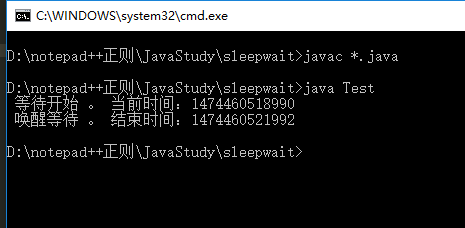
这里是先让 waitThread线程启动起来，然后waitThread线程进入等待状态，并释放了Service对象的锁，这时sleepThread也启动了，来到了mSleep方法的同步代码块，因为之前的waitThread线程已经释放了Service对象的机锁，sleepThread可以拿到对象锁，所以mSleep方法是会被马上调用的。然后sleepThread线程就是进入了睡眠状态，等到3秒休眠结束后调用notifyAll()唤醒了waitThread线程。

### notify()，notifyAll() 的区别

1. wait()、notify/notifyAll() 方法是Object的本地final方法，无法被重写。


2. wait()使当前线程阻塞，前提是 必须先获得锁，一般配合synchronized 关键字使用，即，一般在synchronized 同步代码块里使用 wait()、notify/notifyAll() 方法。


3. 由于 wait()、notify/notifyAll() 在synchronized 代码块执行，说明当前线程一定是获取了锁的。
    - 当线程执行wait()方法时候，会释放当前的锁，然后让出CPU，进入等待状态。
    - 只有当 notify/notifyAll() 被执行时候，才会唤醒一个或多个正处于等待状态的线程，然后继续往下执行，直到执行完synchronized 代码块的代码或是中途遇到wait() ，再次释放锁。
    - 也就是说，notify/notifyAll() 的执行只是唤醒沉睡的线程，而不会立即释放锁，锁的释放要看代码块的具体执行情况。所以在编程中，尽量在使用了notify/notifyAll() 后立即退出临界区，以唤醒其他线程让其获得锁

4. wait() 需要被try catch包围，以便发生异常中断也可以使wait等待的线程唤醒。


5. notify 和wait 的顺序不能错，如果A线程先执行notify方法，B线程在执行wait方法，那么B线程是无法被唤醒的。


6. notify 和 notifyAll的区别
    - notify方法只唤醒一个等待（对象的）线程并使该线程开始执行。所以如果有多个线程等待一个对象，这个方法只会唤醒其中一个线程，选择哪个线程取决于操作系统对多线程管理的实现。
    - notifyAll 会唤醒所有等待(对象的)线程，尽管哪一个线程将会第一个处理取决于操作系统的实现。如果当前情况下有多个线程需要被唤醒，推荐使用notifyAll 方法。比如在生产者-消费者里面的使用，每次都需要唤醒所有的消费者或是生产者，以判断程序是否可以继续往下执行。
    

7. 在多线程中要测试某个条件的变化，使用if 还是while？
    - 要注意，notify唤醒沉睡的线程后，线程会接着上次的执行继续往下执行。所以在进行条件判断时候，可以先把 wait 语句忽略不计来进行考虑；显然，要确保程序一定要执行，并且要保证程序直到满足一定的条件再执行，要使用while进行等待，直到满足条件才继续往下执行。如下代码：

In [12]:
public class K {
    //状态锁
    private Object lock;
    //条件变量
    private int now,need;
    public void produce(int num){
        //同步
        synchronized (lock){
           //当前有的不满足需要，进行等待，直到满足条件
            while(now < need){
                try {
                    //等待阻塞
                    lock.wait();
                } catch (InterruptedException e) {
                    e.printStackTrace();
                }
                System.out.println("我被唤醒了！");
            }
           // 做其他的事情
        }
    }
}

显然，只有当前值满足需要值的时候，线程才可以往下执行，所以，必须使用while 循环阻塞。注意，wait() 当被唤醒时候，只是让while循环继续往下走.如果此处用if的话，意味着if继续往下走，会跳出if语句块。

#### 实现生产者和消费者问题 
什么是生产者-消费者问题呢？
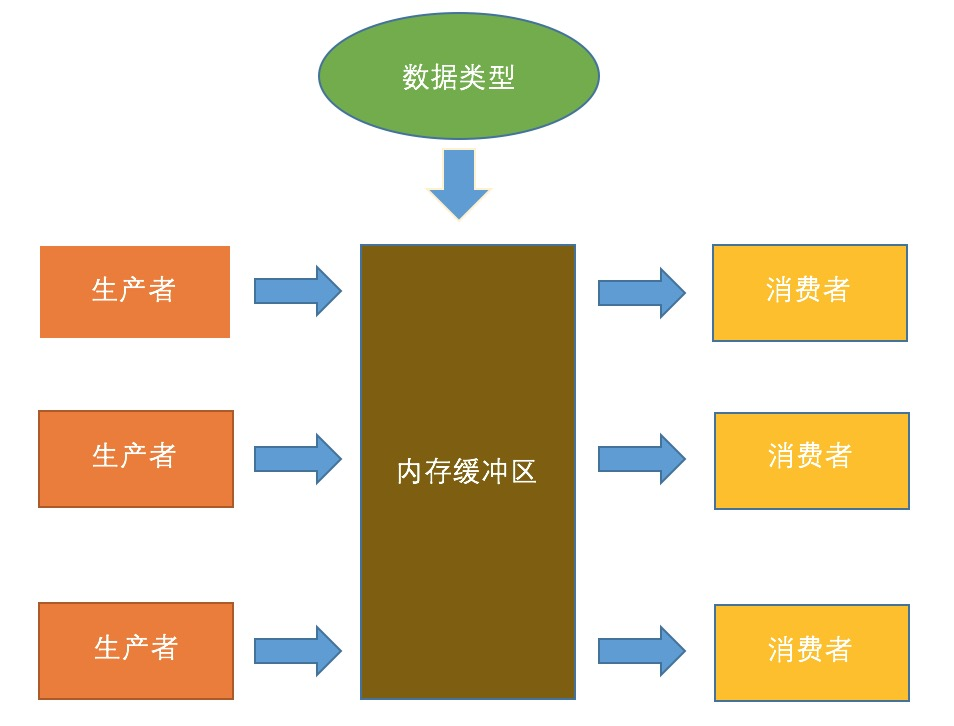
如上图，假设有一个公共的容量有限的池子，有两种人，一种是生产者，另一种是消费者。需要满足如下条件：

1. 生产者产生资源往池子里添加，前提是池子没有满，如果池子满了，则生产者暂停生产，直到自己的生成能放下池子。
2. 消费者消耗池子里的资源，前提是池子的资源不为空，否则消费者暂停消耗，进入等待直到池子里有资源数满足自己的需求。


##### - 抽象仓库类 -

In [16]:
public interface AbstractStorage {
    void consume(int num);
    void produce(int num);
}

##### - 仓库类 -

In [17]:
import java.util.LinkedList;

/**
 *  生产者和消费者的问题
 *  wait、notify/notifyAll() 实现
 */
public class Storage1 implements AbstractStorage {
    //仓库最大容量
    private final int MAX_SIZE = 100;
    //仓库存储的载体
    private LinkedList<Object> list = new LinkedList<Object>();

    //生产产品
    public void produce(int num){
        //同步
        synchronized (list){
            //仓库剩余的容量不足以存放即将要生产的数量，暂停生产
            while(list.size()+num > MAX_SIZE){
                System.out.println("【要生产的产品数量】:" + num + "\t【库存量】:"
                        + list.size() + "\t暂时不能执行生产任务!");

                try {
                    //条件不满足，生产阻塞
                    list.wait();
                } catch (InterruptedException e) {
                    e.printStackTrace();
                }
            }

            for(int i=0;i<num;i++){
                list.add(new Object());
            }

            System.out.println("【已经生产产品数】:" + num + "\t【现仓储量为】:" + list.size());

            list.notifyAll();
        }
    }

    //消费产品
    public void consume(int num){
        synchronized (list){

            //不满足消费条件
            while(num > list.size()){
                System.out.println("【要消费的产品数量】:" + num + "\t【库存量】:"
                        + list.size() + "\t暂时不能执行生产任务!");

                try {
                    list.wait();
                } catch (InterruptedException e) {
                    e.printStackTrace();
                }
            }

            //消费条件满足，开始消费
            for(int i=0;i<num;i++){
                list.remove();
            }

            System.out.println("【已经消费产品数】:" + num + "\t【现仓储量为】:" + list.size());

            list.notifyAll();
        }
    }
}

##### -生产者 -

In [18]:
public class Producer extends Thread{
    //每次生产的数量
    private int num ;

    //所属的仓库
    public AbstractStorage abstractStorage;

    public Producer(AbstractStorage abstractStorage){
        this.abstractStorage = abstractStorage;
    }

    public void setNum(int num){
        this.num = num;
    }

    // 线程run函数
    @Override
    public void run()
    {
        produce(num);
    }

    // 调用仓库Storage的生产函数
    public void produce(int num)
    {
        abstractStorage.produce(num);
    }
}

##### - 消费者 -

In [22]:
public class Consumer extends Thread{
    // 每次消费的产品数量
    private int num;

    // 所在放置的仓库
    private AbstractStorage abstractStorage1;

    // 构造函数，设置仓库
    public Consumer(AbstractStorage abstractStorage1)
    {
        this.abstractStorage1 = abstractStorage1;
    }

    // 线程run函数
    public void run()
    {
        consume(num);
    }

    // 调用仓库Storage的生产函数
    public void consume(int num)
    {
        abstractStorage1.consume(num);
    }

    public void setNum(int num){
        this.num = num;
    }
}

##### - 测试 -

In [23]:
public class Test{
    public static void main() {
        // 仓库对象
        AbstractStorage abstractStorage = new Storage1();

        // 生产者对象
        Producer p1 = new Producer(abstractStorage);
        Producer p2 = new Producer(abstractStorage);
        Producer p3 = new Producer(abstractStorage);
        Producer p4 = new Producer(abstractStorage);
        Producer p5 = new Producer(abstractStorage);
        Producer p6 = new Producer(abstractStorage);
        Producer p7 = new Producer(abstractStorage);

        // 消费者对象
        Consumer c1 = new Consumer(abstractStorage);
        Consumer c2 = new Consumer(abstractStorage);
        Consumer c3 = new Consumer(abstractStorage);

        // 设置生产者产品生产数量
        p1.setNum(10);
        p2.setNum(10);
        p3.setNum(10);
        p4.setNum(10);
        p5.setNum(10);
        p6.setNum(10);
        p7.setNum(80);

        // 设置消费者产品消费数量
        c1.setNum(50);
        c2.setNum(20);
        c3.setNum(30);

        // 线程开始执行
        c1.start();
        c2.start();
        c3.start();

        p1.start();
        p2.start();
        p3.start();
        p4.start();
        p5.start();
        p6.start();
        p7.start();
    }
}

In [26]:
Test.main();

【要消费的产品数量】:50	【库存量】:0	暂时不能执行生产任务!
【要消费的产品数量】:20	【库存量】:0	暂时不能执行生产任务!
【要消费的产品数量】:30	【库存量】:0	暂时不能执行生产任务!
【已经生产产品数】:10	【现仓储量为】:10
【要消费的产品数量】:50	【库存量】:10	暂时不能执行生产任务!
【要消费的产品数量】:30	【库存量】:10	暂时不能执行生产任务!
【要消费的产品数量】:20	【库存量】:10	暂时不能执行生产任务!
【已经生产产品数】:10	【现仓储量为】:20
【要消费的产品数量】:50	【库存量】:20	暂时不能执行生产任务!
【已经消费产品数】:20	【现仓储量为】:0
【要消费的产品数量】:30	【库存量】:0	暂时不能执行生产任务!
【要消费的产品数量】:50	【库存量】:0	暂时不能执行生产任务!
【已经生产产品数】:10	【现仓储量为】:10
【要消费的产品数量】:30	【库存量】:10	暂时不能执行生产任务!
【要消费的产品数量】:50	【库存量】:10	暂时不能执行生产任务!
【已经生产产品数】:10	【现仓储量为】:20
【要消费的产品数量】:30	【库存量】:20	暂时不能执行生产任务!
【要消费的产品数量】:50	【库存量】:20	暂时不能执行生产任务!
【已经生产产品数】:10	【现仓储量为】:30
【已经消费产品数】:30	【现仓储量为】:0
【要消费的产品数量】:50	【库存量】:0	暂时不能执行生产任务!
【已经生产产品数】:10	【现仓储量为】:10
【要消费的产品数量】:50	【库存量】:10	暂时不能执行生产任务!
【已经生产产品数】:80	【现仓储量为】:90


## 总结
sleep() 和 wait() 的区别就是 **调用sleep方法的线程不会释放对象锁，而调用wait() 方法会释放对象锁。**